# Transfer Learning for Computer Vision Tutorial
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import time
import os
import copy

plt.rcParams['figure.figsize'] = [16,8]
plt.ion()  # interactive mode

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

# Ignore warnings for image input
import warnings
warnings.filterwarnings("ignore")

cuda:0
6


In [2]:
data_dir = os.path.join('.', 'data', 'hymenoptera_data')
batch_size=16

In [3]:
# find mean and std-dev from train a batch of training set
train_images = tv.datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transform=tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor()
    ]))
print(len(train_images))

train_loader = torch.utils.data.DataLoader(
    train_images, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)

mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images_str = images.view(batch_samples, images.size(1), -1)
    mean += images_str.mean(2).sum(0)
    std += images_str.std(2).sum(0)

mean = (mean / len(train_loader.dataset)).numpy()
std = (std / len(train_loader.dataset)).numpy()
print(mean, std)

244
[0.5120238  0.46175095 0.33341047] [0.2129148  0.20612963 0.20198347]


In [4]:
data_transforms = {
    'train': tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)
    ]),
    'val': tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)
    ])}

dataset_names = ['train', 'val']

image_datasets = {}
for name in dataset_names:
    image_datasets[name] = tv.datasets.ImageFolder(
        os.path.join(data_dir, name),
        data_transforms[name])

data_loaders = {}
for name in dataset_names:
    data_loaders[name] = torch.utils.data.DataLoader(
        image_datasets[name], 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers)
    
dataset_sizes = {name: len(image_datasets[name]) for name in dataset_names}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


In [5]:
def imshow(grid, title=None):
    '''Convert Tensor to Numpy images, and join a batch of images into one large image
    '''
    # permute the axes according to the values
    # from (3, x, y) tp (x, y, 0)
    grid = grid.numpy().transpose((1,2,0)) 
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])


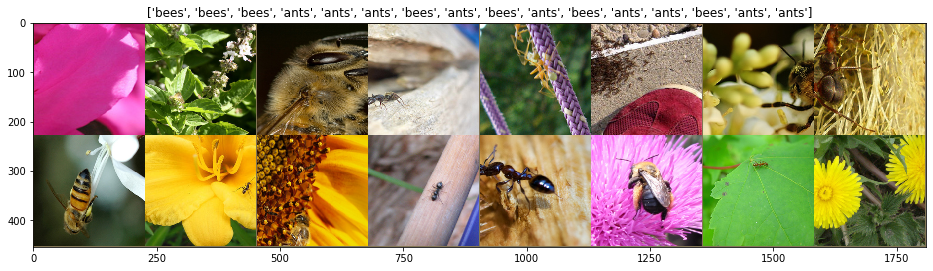

In [6]:
inputs, classes = next(iter(data_loaders['train']))
print(inputs.size())
grid = tv.utils.make_grid(inputs)
print(grid.size())
imshow(grid, title=[class_names[x] for x in classes])

## Training the model

- Scheduling the learning rate
- Saving the best model

In [7]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=50):
    since = time.time()
    
    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in dataset_names:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # ignore value, we only want indices
                    loss = loss_fn(outputs, labels)
                    
                    # backpropagation (for training only)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_state = copy.deepcopy(model.state_dict())
            
        print()
            
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
        
    model.load_state_dict(best_model_state)
    return model

## Visualizing the model predictions

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    print(was_training)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## Finetuning the convnet

In [9]:
model_ft = tv.models.resnet18(pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# get # of input features from the 'fc' layer
num_ftrs = model_ft.fc.in_features

# replace the # out putput in 'fc' layer to 2 (2 classes)
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(
    model_ft, 
    loss_fn, 
    optimizer_ft, 
    exp_lr_scheduler,
    num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5867 Acc: 0.7090
val Loss: 0.3268 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.3067 Acc: 0.9016
val Loss: 0.2184 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2805 Acc: 0.8852
val Loss: 0.2502 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.2290 Acc: 0.9139
val Loss: 0.1584 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1919 Acc: 0.9262
val Loss: 0.1492 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.1514 Acc: 0.9344
val Loss: 0.1530 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.1001 Acc: 0.9713
val Loss: 0.1460 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.1136 Acc: 0.9549
val Loss: 0.1567 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.1547 Acc: 0.9385
val Loss: 0.1660 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.1238 Acc: 0.9549
val Loss: 0.1561 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.1256 Acc: 0.9467
val Loss: 0.1563 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0992 Acc: 0.9631
val Loss: 0.1549 Acc: 0.9477

Ep

False


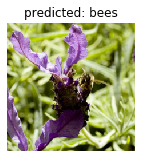

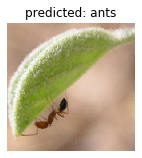

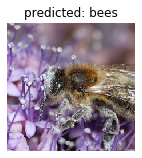

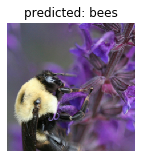

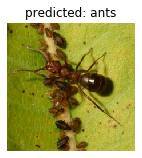

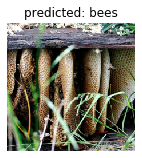

In [13]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [ ]:
# freeze all parameters in the network except the final layer
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
